In [6]:
!pip install mlxtend

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ----------------------- ---------------- 0.8/1.4 MB 8.3 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 8.7 MB/s eta 0:00:00


In [8]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualisierung
import seaborn as sns
import matplotlib.pyplot as plt

# Data Analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [12]:
data_raw = pd.read_csv('MBA.csv', sep=';')
data_raw.head()

C:\Users\Sumit\AppData\Local\Temp\ipykernel_30212\3378973907.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv('MBA.csv', sep=';')


,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55",17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75",17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom


In [14]:
print(data_raw.shape)
print(data_raw.info())

(522064, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity    522064 non-null  int64  
 3   Date        522064 non-null  object 
 4   Price       522064 non-null  object 
 5   CustomerID  388023 non-null  float64
 6   Country     522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB
None


In [16]:
data_raw['Date'] = pd.to_datetime(data_raw['Date'], format='%d.%m.%Y %H:%M')
data_raw['YearMonth'] = data_raw['Date'].dt.to_period('M')
data_raw['Price'] = data_raw['Price'].str.replace(',', '.').astype(float)
missing_values = data_raw.isnull().sum()
print(missing_values)

BillNo             0
Itemname        1455
Quantity           0
Date               0
Price              0
CustomerID    134041
Country            0
YearMonth          0
dtype: int64


In [18]:
data_raw.describe()

,Quantity,Date,Price,CustomerID
count,522064.000000,522064,522064.000000,388023.000000
mean,10.090435,2011-07-04 12:51:20.777107456,3.826801,15316.931710
min,-9600.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 10:15:00,1.250000,13950.000000
50%,3.000000,2011-07-20 08:59:00,2.080000,15265.000000
75%,10.000000,2011-10-19 14:12:00,4.130000,16837.000000
max,80995.000000,2011-12-09 12:50:00,13541.330000,18287.000000
std,161.110525,NaN,41.900599,1721.846964


In [20]:
# Filtering the dataset to include only rows with values > 0
data = data_raw[(data_raw['Quantity']>0) & (data_raw['Price']>0)]
# Dropping rows without item 
data = data[data['Itemname'].notnull()]
# Filling missing customer IDs
data = data.fillna('#NV')
# Calculate total price per pos / transaction
data['TotalPrice'] = data['Quantity'] * data['Price']
data.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country,YearMonth,TotalPrice
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,15.30
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34


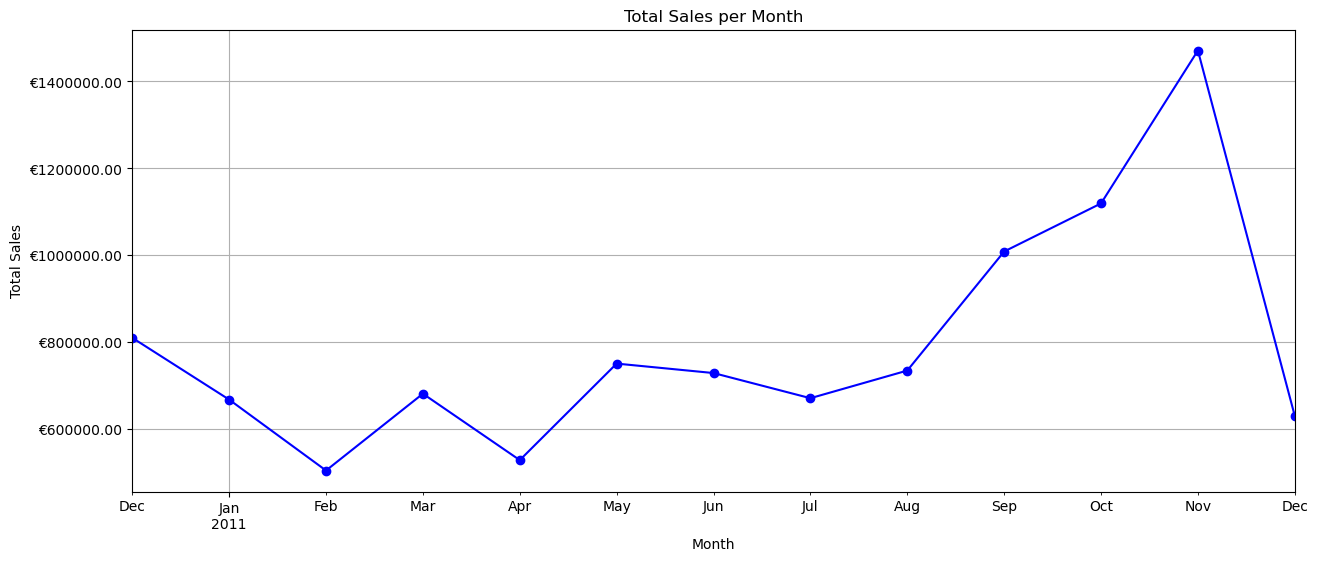

In [22]:
# Grouping the data by month and year, and calculating the total sum of sales
monthly_sales = data.groupby('YearMonth')['TotalPrice'].sum()

plt.figure(figsize=(15,6))
monthly_sales.plot(kind='line', marker='o', color='b')
plt.title('Total Sales per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')

formatter = ticker.FormatStrFormatter('€%.2f')
plt.gca().yaxis.set_major_formatter(formatter)  

plt.grid(True)
plt.show()

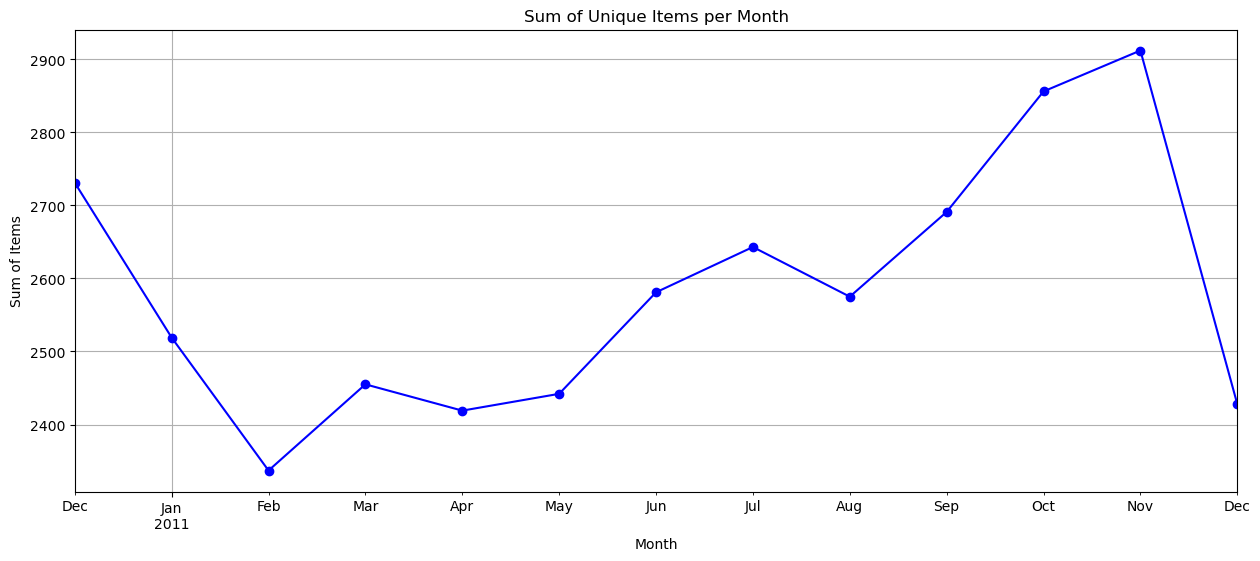

In [24]:
# Grouping the data by month and year, and calculating the unique items per month
monthly_item = data.groupby('YearMonth')['Itemname'].nunique()
plt.figure(figsize=(15,6))
monthly_item.plot(kind='line', marker='o', color='b')
plt.title('Sum of Unique Items per Month')
plt.xlabel('Month')
plt.ylabel('Sum of Items')
plt.grid(True)
plt.show()

In [36]:
# Ensure no missing values
data = data.dropna(subset=['BillNo', 'Itemname'])

# Create a basket matrix: rows = BillNo, columns = Items (1 if bought, else 0)
basket = (
    data.groupby(['BillNo', 'Itemname'])['Itemname']
    .count()
    .unstack()
    .fillna(0)
    .applymap(lambda x: 1 if x > 0 else 0)
)

basket.head()


C:\Users\Sumit\AppData\Local\Temp\ipykernel_30212\3950054355.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: 1 if x > 0 else 0)


Itemname,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
BillNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
basket[basket > 0] = 1

In [42]:
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)

C:\Users\Sumit\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [44]:
rules_confidenz = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)
print(rules_confidenz.shape)
rules_c = rules_confidenz.round(3)
rules_c.head()

(4, 14)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038,0.050,0.031,0.822,16.521,1.0,0.029,5.332,0.976,0.547,0.812,0.721
1,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.031,0.052,0.026,0.851,16.449,1.0,0.025,6.364,0.969,0.466,0.843,0.679
2,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.029,0.050,0.026,0.903,18.161,1.0,0.025,9.831,0.973,0.500,0.898,0.716
3,"(JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SUKI)",(JUMBO BAG RED RETROSPOT),0.026,0.105,0.021,0.802,7.608,1.0,0.018,4.508,0.892,0.190,0.778,0.501


In [46]:
rules_lift = association_rules(frequent_itemsets, metric="lift", min_threshold= 2.5)
print(rules_lift.shape)
rules_l = rules_lift.round(3)
rules_l.head()

(174, 14)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(PACK OF 72 RETROSPOT CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.065,0.041,0.022,0.340,8.337,1.0,0.020,1.454,0.942,0.265,0.312,0.443
1,(60 TEATIME FAIRY CAKE CASES),(PACK OF 72 RETROSPOT CAKE CASES),0.041,0.065,0.022,0.545,8.337,1.0,0.020,2.055,0.917,0.265,0.513,0.443
2,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.039,0.049,0.021,0.542,10.954,1.0,0.019,2.073,0.945,0.313,0.518,0.483
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.049,0.039,0.021,0.425,10.954,1.0,0.019,1.672,0.956,0.313,0.402,0.483
4,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.053,0.049,0.032,0.616,12.468,1.0,0.030,2.478,0.971,0.465,0.596,0.635
